In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as st

# Dataset: FRED-MD

In [2]:
# macroeconomic database of monthly U.S. indicators 
# such as output and income, the labor market and prices from 1959 to 2020
df = pd.read_csv(r"current.csv")
df

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,Transform:,5.000,5.0,5.000,5.000000e+00,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.00,6.00,6.00,2.0,6.0,6.00,6.00,6.0000,1.0000
1,1/1/1959,2437.296,2288.8,17.302,2.922588e+05,18235.77392,22.6250,23.4581,22.1904,32.4078,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.00,12298.00,84.2043,NaN
2,2/1/1959,2446.902,2297.0,17.482,2.944295e+05,18369.56308,23.0681,23.7747,22.3827,32.6455,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.00,12298.00,83.5280,NaN
3,3/1/1959,2462.689,2314.0,17.647,2.934254e+05,18523.05762,23.4004,23.9186,22.4925,32.6455,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.00,12349.00,81.6405,NaN
4,4/1/1959,2478.744,2330.3,17.584,2.993317e+05,18534.46600,23.8989,24.2641,22.8221,33.1606,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.00,12484.00,81.8099,NaN
5,5/1/1959,2493.228,2345.8,17.796,3.013730e+05,18679.66354,24.2589,24.4655,23.0418,33.3190,...,11.454,2.17,2.48,2.08,95.3,280.1,6753.00,12646.00,80.7315,NaN
6,6/1/1959,2500.989,2352.9,17.861,3.013648e+05,18849.75209,24.2866,24.6382,23.2066,33.1606,...,11.496,2.17,2.50,2.09,NaN,281.9,6956.00,12926.00,78.6972,NaN
7,7/1/1959,2499.525,2351.0,17.801,3.050348e+05,18843.52934,23.7050,24.6670,23.3988,33.5964,...,11.537,2.17,2.51,2.09,NaN,283.1,7132.00,13199.00,78.9984,NaN
8,8/1/1959,2485.330,2337.6,17.908,2.894246e+05,18963.83587,22.9019,24.4943,23.3439,33.6360,...,11.571,2.17,2.53,2.07,NaN,284.2,7309.00,13471.00,77.3045,NaN
9,9/1/1959,2487.290,2337.5,18.088,2.937150e+05,18715.96293,22.8743,24.3792,23.2615,33.5171,...,11.605,2.17,2.54,2.08,NaN,284.3,7393.00,13657.00,76.8926,NaN


In [3]:
# drop any column that has a nan value
# fred = df[252:-2].dropna()
fred = df[1:].dropna()
# it turns out coronavirus is causing a huge number of outliers in our data, so we will drop the months after march 2020
fred = fred[:-4]

# transform it into an numpy ndarray, and set aside the dates
fred = fred.to_numpy().T
months = fred[0]
fred = np.delete(fred, 0, 0)
fred

array([[7968.831, 7982.053000000001, 8011.806, ..., 16975.578999999998,
        17105.811999999998, 17219.643],
       [6879.1, 6884.7, 6903.6, ..., 14127.4, 14218.2, 14328.1],
       [55.965, 56.067, 56.114, ..., 121.385, 121.89399999999999,
        121.765],
       ...,
       [189752.08, 190887.95, 190911.8, ..., 729108.6, 727386.85,
        723310.6],
       [744.2592, 749.7716, 755.9008, ..., 3829.6324, 3840.9518,
        3875.3547],
       [17.0505, 16.2227, 16.1885, ..., 13.3469, 14.0814, 20.3778]],
      dtype=object)

In [4]:
# difference the non-stationary series to stationarity
# check for non-stationary and take differences of non-stationary series
def non_stationary(timeseries):
    # Perform augmented Dickey-Fuller test and return whether the test statistic is greater than the critical value,
    # which means the time series is non-stationary. We pick an alpha = 0.10
    dftest = st.adfuller(timeseries, autolag='AIC')
    test_statistic = dftest[0]
    crit_value = dftest[4]['10%']
    return test_statistic > crit_value

stationary_fred = fred.copy()
print(stationary_fred.shape)
for i in range(len(stationary_fred)):
    if non_stationary(stationary_fred[i]):
        diffs = []
        for j in range(1, len(stationary_fred[i])):
            diffs.append(stationary_fred[i][j] - stationary_fred[i][j-1])
        diffs.insert(0, np.mean(diffs))
        stationary_fred[i] = diffs


(128, 337)


In [7]:
# standardize the series to have zero mean and unit variance before extracting principal components
def center(series):
    zero_mean = series - np.mean(series)
    unit_variance = zero_mean / (np.std(series))
    return unit_variance

In [8]:
whitened_fred = np.empty(shape=(0,0))
for col in stationary_fred:
    # don't apply this to malformed columns, i.e. columns with nan or non-floats
    if not isinstance(col[0], str):
        whitened_fred = np.append(whitened_fred, center(col))
whitened_fred = whitened_fred.reshape(stationary_fred.shape)

In [9]:
# test 
# for col in whitened_fred:
#     print(np.mean(col), "\t", np.std(col))

24
63
64
3


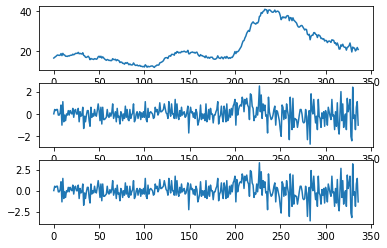

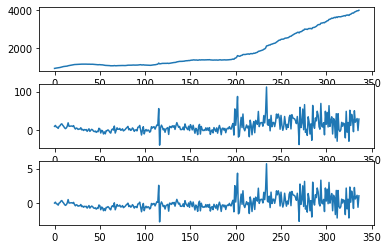

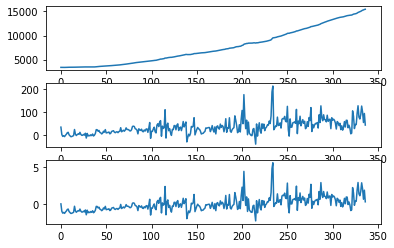

In [10]:
def plotter(index):
    fig, axs = plt.subplots(3)
    fig.figsize = [6.4, 9.6]
    axs[0].plot(fred[index])
    axs[1].plot(stationary_fred[index])
    axs[2].plot(whitened_fred[index])
# plotter(48)
count = 0
for i in range(len(whitened_fred)):
    if non_stationary(whitened_fred[i]):
        count += 1
        print(i)
        plotter(i)
print(count)

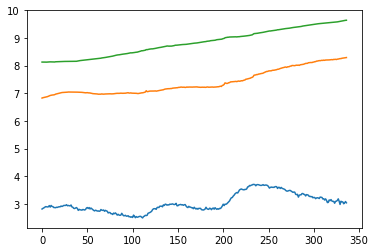

In [13]:
# plt.plot([np.log(i) for i in fred[24]])
# plt.plot([np.log(i) for i in fred[63]])
# plt.plot([np.log(i) for i in fred[64]])